In [56]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.utils.data
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from deap import algorithms, base, creator, tools
import copy
import operator
import tqdm
import random

In [13]:
# load all data
data = pd.read_csv('SFEW.csv',  header=None, skiprows=1)

# drop first column
data.drop(data.columns[0], axis=1, inplace=True)

#remove Nan PHOG descriptor pattern
data.drop([205], axis=0, inplace=True)

# try shuffle data
data = data.sample(frac=1).reset_index(drop=True)

#normalisation of features
for column in data:
    if column == 1:
        pass
    else:
        data[column] = data.loc[:, [column]].apply(lambda x: (x - x.mean()) / x.std())
        
# stratified 10-fold split into training set and testing set
X = data.iloc[:,1:11].values
Y = data.iloc[:,0].values-1

skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
split_data = skf.split(X,Y)

folded_data = []
for train_index, test_index in split_data:
    # Split train-test
    X_train, X_test = torch.Tensor(X[train_index]), torch.Tensor(X[test_index])
    Y_train, Y_test = torch.Tensor(Y[train_index]).long(), torch.Tensor(Y[test_index]).long()
    train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    folded_data.append([X_train,Y_train,X_test,Y_test,train_loader])

In [14]:
# define the three-layer neural network
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        first = self.fc1(x)
        act = self.sigmoid(first)
        out = self.fc2(act)
        return act, out  #outputs both the hidden layer activation matrix and the output classification
    
# define the loss function
criterion = nn.CrossEntropyLoss()

In [15]:
# define a function to plot confusion matrix
def plot_confusion(input_sample, num_classes, des_output, actual_output):
    confusion = torch.zeros(num_classes, num_classes)
    for i in range(input_sample):
        actual_class = actual_output[i]
        predicted_class = des_output[i]

        confusion[actual_class][predicted_class] += 1

    return confusion

In [16]:
# training step for batch training
def train_step(model, optimizer, loader):
    for step, (batch_x, batch_y) in enumerate(loader):
        X = batch_x
        Y = batch_y.long()
        _, outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        return loss.item()

# distinctiveness pruning step
def prune(model, x, theta):
    n_neu = model.fc1.weight.data.size(0) #initial number of neurons
    activation, _ = model(x)
    cos = nn.CosineSimilarity(dim=0, eps=1e-6) # calculates cosine similarity between column vectors
    activation += torch.full(activation.size(), -0.5) #normalise activation vectors
    keep = list(range(n_neu)) #generate list of column indices to keep track of neurons
    for j in range(n_neu):
        for k in range(j+1,n_neu):
            angle = cos(activation[:,j],activation[:,k])
            n_neu = model.fc1.weight.data.size(0)
            if angle.item() >= math.cos(math.radians(theta)) and k in keep:  # similar neurons
                model.fc1.weight.data[j] += model.fc1.weight.data[k]
                model.fc1.bias.data[j] += model.fc1.bias.data[k]
                model.fc2.weight.data[:,j] += model.fc2.weight.data[:,k] # adds together all weights and biases from k to j
                keep.remove(k) #removes neuron k from list
            if angle.item() <= math.cos(math.radians(180-theta)) and k in keep and j in keep: # complementary neurons
                keep.remove(k) #removes neuron k and j from list
                keep.remove(j)
    model.fc1.weight.data = model.fc1.weight.data[keep]
    model.fc2.weight.data = model.fc2.weight.data[:,keep] # removes all relevant weights and biases from the model
    model.fc1.bias.data = model.fc1.bias.data[keep]
    return model

In [21]:
#classification accuracy
def accuracy(model, X, Y):
    _, outputs = model(X)
    _, predicted = torch.max(outputs, 1)
    total = predicted.size(0)
    correct = sum(predicted.data.numpy() == Y.data.numpy())
    return 100*correct/total

In [23]:
#classwise precision, recall, specificity matrix
def plot_prs(inputs, num_classes, targets, outputs):
    confusion = plot_confusion(inputs, num_classes, targets, outputs)
    prs = torch.zeros(3, num_classes)
    
    def div(n, d):
        if d == 0:
            return 0
        else:
            return n / d
    
    for i in range(num_classes):
        tp = confusion[i,i].item() # true postive
        fp = (sum(confusion[:,i])-confusion[i,i]).item() #false positive
        fn = (sum(confusion[i,:])-confusion[i,i]).item() #false negative
        tn = targets.size(0)-tp-fp-fn #true negative
        
        prs[:,i] = torch.Tensor([div(tp,tp+fp),div(tp,tp+fn),div(tn,tn+fp)])
    return prs

In [19]:
#part 1: neural network hyperparamaterisation

# plots the accuracy v epoch graph of a regular neural network
def normal_NN_graph(num_epoch, num_hidden, lr, data):
    net = Net(10, num_hidden, 7)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    train_acc = []
    test_acc = []

    for epoch in range(num_epoch):
        train_step(net, optimizer, data[4])
        train_acc.append(accuracy(net, data[0], data[1]))
        test_acc.append(accuracy(net, data[2], data[3])) #calculate accuracy at each epoch
    
    print('neurons:', num_hidden,', lr: ', lr)
    print('Training Accuracy: %.2f %%' % accuracy(net, data[0], data[1]))
    print('Testing Accuracy: %.2f %%' % accuracy(net, data[2], data[3]))

    # plot accuracy v epoch
    plt.figure()
    plt.title('Classification accuracy during training')
    plt.plot(train_acc, label="training")
    plt.plot(test_acc, label="testing")
    plt.xlabel('Training epoch')
    plt.ylabel('Overall Accuracy (%)')
    plt.legend()
    plt.show()
    
    # plot PRS tensor
    _, predicted = torch.max(test_out, 1)
    print(plot_prs(data[2].shape[0], 7, predicted.long().data, data[3].data))
    
# calculate average testing accuracy for a normal neural network
def normal_NN(num_epoch, num_hidden, lr):
    test_acc = []
    for data in folded_data: #cross-validation
        net = Net(10, num_hidden, 7)
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
        for epoch in range(num_epoch):
            train_step(net, optimizer, data[4])
        test_acc.append(accuracy(net, data[2], data[3]))
    return np.mean(np.array(test_acc), axis=0)

In [ ]:
# calculate testing accuracies for a variety of networks
lr_list = [0.01,0.001,0.0001]
hidden_list = [10,20,50,100,200,500,1000]

opt_tensor = torch.Tensor([[normal_NN(300, h, lr) for h in hidden_list] for lr in lr_list])
print("Hyperparameter testing:")
print("table of testing accuracies of networks with varying hidden neurons and learning rates")
print(opt_tensor)

In [28]:
# calculate average PRS tensor
def prs_plot_ave(num_epoch, num_hidden, lr):
    prs_list = []
    for data in folded_data:
        net = Net(10, num_hidden, 7)
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
        for epoch in range(num_epoch):
            train_step(net, optimizer, data[4])
        _, test_out = net(data[2])
        _, predicted = torch.max(test_out, 1)
        prs_list.append(plot_prs(data[2].shape[0], 7, predicted.long().data, data[3].data))
    return torch.mean(torch.stack(prs_list), dim=0)

print("Precision, recall, and specificity for 20 hidden neurons and a learning rate of 0.01 after 300 training epochs")
prs_plot_ave(300,20,0.01)

Precision, recall, and specificity for 20 hidden neurons and a learning rate of 0.01 after 300 training epochs


tensor([[0.2060, 0.1786, 0.2461, 0.2798, 0.3068, 0.2463, 0.2339],
        [0.1600, 0.0839, 0.2633, 0.4500, 0.3000, 0.1500, 0.2200],
        [0.8780, 0.9599, 0.8450, 0.7872, 0.8611, 0.9039, 0.8713]])

In [ ]:
#part 2: pruned networks

# collecting data about accuracy and number of neurons before and after pruning
def neuron_pruning(data):
    before_acc = []
    after_acc = []
    before_neuron = []
    after_neuron = []
    
    for neuron in [20, 50, 100, 200, 500, 1000]:
        net = Net(10,neuron,7)
        optimizer = torch.optim.Adam(net.parameters(), 0.01)

        for epoch in range(300):
            train_step(net, optimizer, data[4])
            
        before_neuron.append(neuron)
        before_acc.append(accuracy(net, data[2], data[3]))

        prune(net, data[0], 15)
        after_neuron.append(net.fc1.weight.data.size(0))
        after_acc.append(accuracy(net, data[2], data[3]))
    
    return torch.Tensor([before_acc, after_acc, before_neuron, after_neuron])

# 10-fold cross validation - run 5 times and averaged
part2_data = []
for x in range(5):
    for data in folded_data:
        part2_data.append(neuron_pruning(data))
part2_data = torch.mean(torch.stack(part2_data), dim=0)

In [ ]:
plt.figure
#plt.title('Number of hidden neurons pruned')
plt.plot(part2_data[2], part2_data[3], 'bo')
plt.plot(part2_data[2], part2_data[3])
plt.xlabel('Initial number of neurons')
plt.ylabel('Final number of neurons')
plt.show()

plt.figure
#plt.title('Network accuracy before and after distinctiveness pruning')
plt.plot(part2_data[2], part2_data[0], 'bo', label = 'before')
plt.plot(part2_data[2], part2_data[0])
plt.plot(part2_data[2], part2_data[1])
plt.plot(part2_data[2], part2_data[1], 'ro', label = 'after')
plt.legend()
plt.xlabel('Initial number of neurons')
plt.ylabel('Overall Accuracy (%)')
plt.show()

In [41]:
#part 3: distinctiveness threshold

# collect data of final number of neurons and testing accuracy based on theta (distinctiveness threshold)
def theta_pruning(data):
    test_acc = []
    theta_list = []
    final_neurons = []

    net = Net(10,100,7)
    optimizer = torch.optim.Adam(net.parameters(), 0.01)
    
    for epoch in range(300):
        train_step(net, optimizer, data[4])
    
    for theta in range(0,95,5):
        model = copy.deepcopy(net) #make a copy of the net for each theta angle
        prune(model, data[0], theta)
        theta_list.append(theta)
        final_neurons.append(100-model.fc1.weight.data.size(0))
        test_acc.append(accuracy(model, data[2], data[3]))
    
    return torch.Tensor([theta_list, final_neurons, test_acc])

In [51]:
# 10-fold cross validation - run 5 times and averaged
part3_data = []
for x in range(5):
    for data in folded_data:
        part3_data.append(theta_pruning(data))
part3_data = torch.mean(torch.stack(part3_data), dim=0)

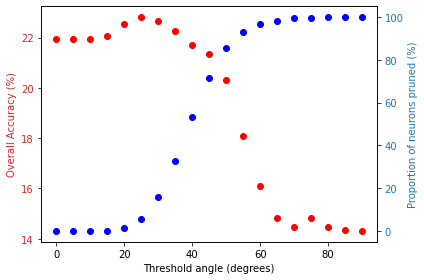

In [52]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Threshold angle (degrees)')
ax1.set_ylabel('Overall Accuracy (%)', color=color)
ax1.plot(part3_data[0], part3_data[2], 'ro')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Proportion of neurons pruned (%)', color=color)  # we already handled the x-label with ax1
ax2.plot(part3_data[0], part3_data[1], 'bo')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [71]:
#part 4: genetic algorithm

#genetic algorithm hyperparameter testing
def evaluation(individual, net, data, N, lam, f):
    model = copy.deepcopy(net)
    #turn chromosome into keep list
    keep = [i for i, x in enumerate(individual) if x == 1]
    #keep hidden neurons in model, remove all others
    model.fc1.weight.data = model.fc1.weight.data[keep]
    model.fc2.weight.data = model.fc2.weight.data[:,keep] # removes all relevant weights and biases from the model
    model.fc1.bias.data = model.fc1.bias.data[keep]
    #check fitness
    if f==0:
        fitness = accuracy(model, data[0], data[1]) - lam*len(keep)/N
    if f==1:
        fitness = accuracy(model, data[0], data[1]) - lam*len(keep)
    return [fitness]

def GA_accuracy(individual, net, data, N):
    model = copy.deepcopy(net)
    #turn chromosome into keep list
    keep = [i for i, x in enumerate(individual) if x == 1]
    #keep hidden neurons in model, remove all others
    model.fc1.weight.data = model.fc1.weight.data[keep]
    model.fc2.weight.data = model.fc2.weight.data[:,keep] # removes all relevant weights and biases from the model
    model.fc1.bias.data = model.fc1.bias.data[keep]
    #check fitness
    train_acc = accuracy(model, data[0], data[1])
    test_acc = accuracy(model, data[2], data[3])
    return train_acc, test_acc

def GA(net, N, lam, f, data):
    toolbox = base.Toolbox()
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, N)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxOnePoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    toolbox.register("evaluate", lambda x: evaluation(x, net, data, N, lam, f))
    toolbox.register("select", tools.selTournament, tournsize=3)
    hof = tools.HallOfFame(5)
    pop = toolbox.population(n=100)
    
    fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
    fit_stats.register('mean', np.mean)
    fit_stats.register('max', np.max)
    result, log = algorithms.eaSimple(toolbox.population(n=100), toolbox, cxpb=0.8, mutpb=0.2, ngen=50, halloffame=hof, verbose=False,
                                      stats=fit_stats)
    
    best_individual = tools.selBest(result, k=1)[0]
    best_keep = [i for i, x in enumerate(best_individual) if x == 1]
    f_train, f_test = GA_accuracy(best_individual, net, data, N)
    f_N = len(best_keep)
    f_N_perc = len(best_keep)/N*100
    return f_train, f_test, f_N, f_N_perc

def GA_func(N_list, lam_list, f, data):
    N_data = []
    for N in N_list:
        net = Net(10, N, 7)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
        for epoch in range(300):
            train_step(net, optimizer, data[4])
        i_train = accuracy(net, data[0], data[1])
        i_test = accuracy(net, data[2], data[3])
        
        lam_data = []
        for lam in lam_list:
            f_train, f_test, f_N, f_N_perc = GA(net, N, lam, f, data)
            lam_data.append([N, lam, i_train, i_test, f_train, f_test, f_N, f_N_perc])
        N_data.append(np.array(lam_data))
    
    return np.stack(N_data)

In [72]:
N_list = [20,50,100,200,500]
lam_list_0 = [-5,-2.5,-1,0,1,2,3,4,5,10,20]

# 10-fold cross validation - run 5 times and averaged
hyp_data_0 = []
for data in folded_data:
    hyp_data_0.append(GA_func(N_list, lam_list_0, 0, data))
hyp_data_0 = np.mean(np.array(hyp_data_0), axis=0)

/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(11, 4))
for i in range(len(N_list)):
    plt.plot(lam_list_0, hyp_data_0[i,:,5], label=str(hyp_data_0[i,0,0])+' neurons')
plt.legend()
plt.ylabel('Final testing accuracy'); plt.xlabel('Lambda');

plt.figure(figsize=(11, 4))
for i in range(len(N_list)):
    plt.plot(lam_list_0, hyp_data_0[i,:,4], label=str(hyp_data_0[i,0,0])+' neurons')
plt.legend()
plt.ylabel('Final training accuracy'); plt.xlabel('Lambda');

In [ ]:
N_list = [20,50,100,200,500]
lam_list_1 = [0,0.1,0.25,0.5,0.75,1,2]

# 10-fold cross validation - run 5 times and averaged
hyp_data_1 = []
for data in folded_data:
    hyp_data_1.append(GA_func(N_list, lam_list_1, 0, data))
hyp_data_1 = np.mean(np.array(hyp_data_1), axis=0)

In [ ]:
plt.figure(figsize=(11, 4))
for i in range(len(N_list)):
    plt.plot(lam_list_1, hyp_data_1[i,:,5], label=str(hyp_data_1[i,0,0])+' neurons')
plt.legend()
plt.ylabel('Final testing accuracy'); plt.xlabel('Lambda');

In [77]:
#part 5: comparison of pruning techniques

def prune_step(net, data, theta):
    model = prune(copy.deepcopy(net), data[0], theta)
    test_acc = accuracy(model, data[2], data[3])
    f_N = model.fc1.weight.data.size(0)
    return test_acc, f_N

def comparison_func(N_list, data):
    N_data = []
    for i_N in N_list:
        net = Net(10, i_N, 7)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
        for epoch in range(300):
            train_step(net, optimizer, data[4])
        i_test = accuracy(net, data[2], data[3])
        
        _, GA_test, GA_N, _ = GA(net, i_N, 2, 0, data)
        p15_test, p15_N = prune_step(net, data, 15)
        p40_test, p40_N = prune_step(net, data, 40)
        N_data.append([i_N, i_test, GA_N, GA_test, p15_N, p15_test, p40_N, p15_test])
        print(i_N)
    return np.array(N_data)

In [78]:
N_list_comp = [20,50,100,200,500]

# 10-fold cross validation
comp_data = []
for data in folded_data:
    comp_data.append(comparison_func(N_list_comp, data))
    print('ye')
comp_data = np.mean(np.array(comp_data), axis=0)

20
50
100
200
500
ye
20
50
100
200
500
ye
20
50
100
200
500
ye
20
50
100
200
500
ye
20
50
100
200
500
ye
20
50
100
200
500
ye
20
50
100
200
500
ye
20
50
100
200
500
ye
20
50
100
200
500
ye
20
50
100
200
500
ye


In [ ]:
#testing accuracies for each method vs initial hidden size
#final hidden size vs initial hidden size